# Amazon Reviews Sentiment Analysis

### Parameters

In [1]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLEANING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"

### Read Dataset

### Dataset details
* **sentiment**: the sentiment for the review (2 is positive, 1 is negative)
* **title**: the title of the review
* **content**: the content of the review

In [2]:
import pandas as pd

In [3]:
train_size = 9000
test_size = 1000

In [4]:
train = pd.read_csv("amazon/train.csv", header=None)
columns = ['sentiment', 'title', 'content']
train.rename(columns=dict(zip(train.columns, columns)), inplace=True)
train.head()

,sentiment,title,content
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [5]:
positive_df = train[train['sentiment'] == 2]
negative_df = train[train['sentiment'] == 1]

In [6]:
positive_sample = positive_df.sample(n=train_size, replace=False, random_state=10)
negative_sample = negative_df.sample(n=train_size, replace=False, random_state=10)

In [7]:
train = pd.concat([positive_sample, negative_sample])
train = train.sample(frac=1, random_state=10)
train['sentiment'] = train['sentiment'].map({1:0, 2:1})
train['text'] = train['title'] + train['content']
train = train.drop(columns=['title', 'content'])
train = train.reset_index(drop=True)
train.shape

(18000, 2)

In [8]:
train.head()

,sentiment,text
0,0,Bad research?I started to read Games of State ...
1,1,A great readWe Should Never Meet is one of the...
2,1,Rodgers & Hammerstein's CINDERELLALOVE LOVE LO...
3,0,Pathetic.The only reason i rated this item at ...
4,0,"MisleadingThis was supposed to be about going,..."


In [9]:
test = pd.read_csv("amazon/test.csv", header = None)
columns = ['sentiment', 'title', 'content']
test.rename(columns=dict(zip(test.columns, columns)), inplace=True)
test.head()

,sentiment,title,content
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [10]:
positive_df = test[test['sentiment'] == 2]
negative_df = test[test['sentiment'] == 1]

In [11]:
positive_sample = positive_df.sample(n=test_size, replace=False, random_state=10)
negative_sample = negative_df.sample(n=test_size, replace=False, random_state=10)

In [12]:
test = pd.concat([positive_sample, negative_sample])
test = test.sample(frac=1, random_state=10)
test['sentiment'] = test['sentiment'].map({1:0, 2:1})
test['text'] = test['title'] + test['content']
test = test.drop(columns=['title', 'content'])
test = test.reset_index(drop=True)
test.shape

(2000, 2)

In [13]:
test.head()

,sentiment,text
0,1,I think it works...I can't really say for sure...
1,0,Not up to the hypeI got this as a gold box dea...
2,0,Not The BestAfter trying unsuccessfully to get...
3,1,Just discovered this group -- glad I didSaw a ...
4,0,"1 star is generous...Like many others, I watch..."


### Map target label to String
* **0** -> **NEGATIVE**
* **1** -> **POSITIVE**

In [14]:
decode_map = {0: "NEGATIVE", 1: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [15]:
%%time
train.sentiment = train.sentiment.apply(lambda x: decode_sentiment(x))
test.sentiment = test.sentiment.apply(lambda x: decode_sentiment(x))

CPU times: user 5.62 ms, sys: 0 ns, total: 5.62 ms
Wall time: 5.3 ms


In [16]:
from collections import Counter
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sentiment distribuition')

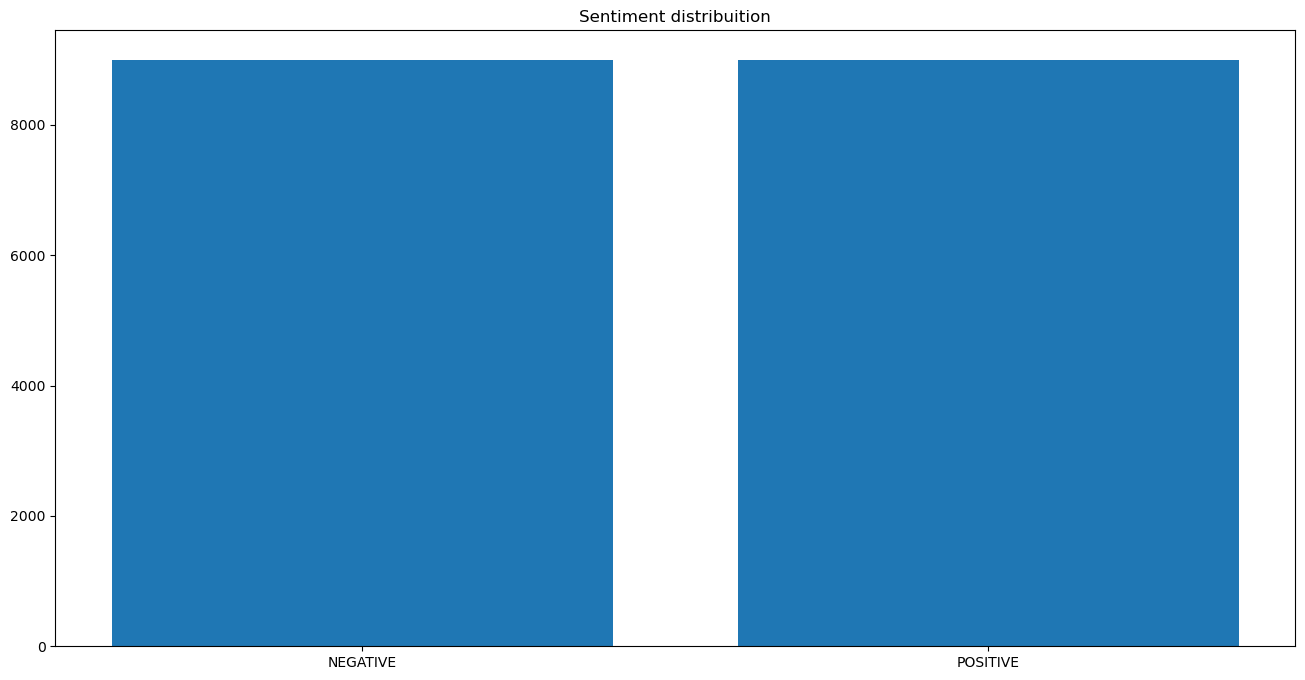

In [17]:
target_cnt = Counter(train.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Sentiment distribuition")

### Preprocessing

In [18]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [19]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [20]:
def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [21]:
%%time
train.text = train.text.apply(lambda x: preprocess(x))
test.text = test.text.apply(lambda x: preprocess(x))

CPU times: user 2.81 s, sys: 4.48 ms, total: 2.82 s
Wall time: 2.82 s


In [22]:
train.head()

,sentiment,text
0,NEGATIVE,bad research started read games state days ago...
1,POSITIVE,great readwe never meet one best short story c...
2,POSITIVE,rodgers hammerstein cinderellalove love love a...
3,NEGATIVE,pathetic reason rated item 1 star give 0 worth...
4,NEGATIVE,misleadingthis supposed going really nothing t...


### Word2Vec

In [23]:
%%time
documents = [_text.split() for _text in train.text] 

CPU times: user 45.7 ms, sys: 26.5 ms, total: 72.1 ms
Wall time: 71.4 ms


In [24]:
import gensim

In [25]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [26]:
w2v_model.build_vocab(documents)

In [27]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 7548


In [28]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 1min 45s, sys: 205 ms, total: 1min 45s
Wall time: 14.7 s


(19306634, 23378816)

In [29]:
w2v_model.wv.most_similar("glass") 

[('ceramic', 0.5267015099525452),
 ('carafe', 0.5255014896392822),
 ('container', 0.5254523754119873),
 ('lid', 0.5189043879508972),
 ('jar', 0.5179300308227539),
 ('towels', 0.5069493055343628),
 ('siphon', 0.5036386847496033),
 ('coating', 0.5029833316802979),
 ('butter', 0.4911379814147949),
 ('thermos', 0.49047723412513733)]

### Tokenize Text

In [30]:
from keras.preprocessing.text import Tokenizer

2023-05-16 15:47:44.935729: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 15:47:44.981822: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-16 15:47:47.470787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 55442
CPU times: user 825 ms, sys: 12 ms, total: 837 ms
Wall time: 834 ms


In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 665 ms, sys: 44.4 ms, total: 709 ms
Wall time: 707 ms


In [34]:
x_train[0:5]

array([[    0,     0,     0, ...,   246,   581,     1],
       [    0,     0,     0, ...,  5629,  9702,   682],
       [    0,     0,     0, ...,    16,   146,  7550],
       [    0,     0,     0, ...,  1041,    17,   472],
       [    0,     0,     0, ..., 25031,   583,   297]], dtype=int32)

### Label Encoder 

In [35]:
labels = train.sentiment.unique().tolist()
labels

['NEGATIVE', 'POSITIVE']

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
encoder = LabelEncoder()
encoder.fit(train.sentiment.tolist())

y_train = encoder.transform(train.sentiment.tolist())
y_test = encoder.transform(test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (18000, 1)
y_test (2000, 1)


In [38]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (18000, 300)
y_train (18000, 1)

x_test (2000, 300)
y_test (2000, 1)


In [39]:
y_train[:10]

array([[0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

### Embedding layer

In [40]:
import numpy as np

In [41]:
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

In [42]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(55442, 300)


In [43]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [44]:
from keras.models import Sequential

In [45]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2023-05-16 15:47:52.667850: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          16632600  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 16,793,101
Trainable params: 160,501
Non-trainable params: 16,632,600
_________________________________________________________________


### Compile model

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [47]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [48]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [49]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
16/16 [==============================] - 30s 2s/step - loss: 0.6234 - accuracy: 0.6466 - val_loss: 0.5088 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 2/8
16/16 [==============================] - 25s 2s/step - loss: 0.5108 - accuracy: 0.7492 - val_loss: 0.4971 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 3/8
16/16 [==============================] - 25s 2s/step - loss: 0.4873 - accuracy: 0.7770 - val_loss: 0.4957 - val_accuracy: 0.7883 - lr: 0.0010
Epoch 4/8
16/16 [==============================] - 25s 2s/step - loss: 0.4701 - accuracy: 0.7794 - val_loss: 0.4319 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 5/8
16/16 [==============================] - 25s 2s/step - loss: 0.4524 - accuracy: 0.7894 - val_loss: 0.4567 - val_accuracy: 0.8028 - lr: 0.0010
Epoch 6/8
16/16 [==============================] - 25s 2s/step - loss: 0.4399 - accuracy: 0.7995 - val_loss: 0.4143 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 7/8
16/16 [==============================] - 25s 2s/step - loss: 0.4290 - accuracy

### Evaluate

In [50]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

2/2 [==============================] - 1s 472ms/step - loss: 0.4656 - accuracy: 0.8120

ACCURACY: 0.8119999766349792
LOSS: 0.4655936360359192
CPU times: user 18.8 s, sys: 1.59 s, total: 20.4 s
Wall time: 1.06 s


### Predict

In [51]:
def decode_sentiment(score):
        return NEGATIVE if score < 0.5 else POSITIVE

In [52]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

### Save Model

In [53]:
model.save('model.h5')

In [54]:
import pickle

In [55]:
with open("tokenizer_model.pkl", "wb") as file:
    pickle.dump(tokenizer, file)

In [56]:
import time

In [57]:
predict("I love the music")

1/1 [==============================] - 0s 399ms/step


{'label': 'POSITIVE',
 'score': 0.9492607116699219,
 'elapsed_time': 0.4609801769256592}

In [58]:
predict("I hate the rain")

1/1 [==============================] - 0s 67ms/step


{'label': 'POSITIVE',
 'score': 0.5891791582107544,
 'elapsed_time': 0.1107172966003418}

In [59]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 65ms/step


{'label': 'POSITIVE',
 'score': 0.7888977527618408,
 'elapsed_time': 0.1068572998046875}